In [2]:
import pandas as pd

import torch
import torch.utils.data as torch_data

from matplotlib import pyplot as plt

df = pd.read_csv("assets/diabetes.csv", sep="\t")
df['Class'] = pd.qcut(df.Y, 10, labels=False)

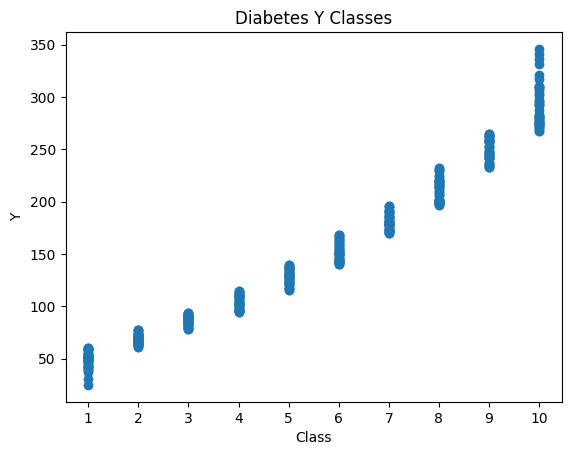

In [3]:
def visualize_deciles():
    fig = plt.figure()
    plt.scatter(df.Class, df.Y)
    ax = fig.axes[0]
    ax.set_xlabel("Class")
    ax.set_ylabel("Y")
    ax.set_title("Diabetes Y Classes")
    ax.set_xticks(range(10), (str(i+1) for i in range(10)))

visualize_deciles()

In [5]:
# Our custom Dataset. Useful reference:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class DiabetesDataset(torch_data.Dataset):
    df: pd.DataFrame

    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> torch.Tensor:
        return torch.tensor(self.df.iloc[index].values)

diabetes_dataset = DiabetesDataset(df)
data_loader = torch_data.DataLoader(diabetes_dataset, 10)

# print the first batch
print(next(iter(data_loader)))

tensor([[ 59.0000,   2.0000,  32.1000, 101.0000, 157.0000,  93.2000,  38.0000,
           4.0000,   4.8598,  87.0000, 151.0000,   5.0000],
        [ 48.0000,   1.0000,  21.6000,  87.0000, 183.0000, 103.2000,  70.0000,
           3.0000,   3.8918,  69.0000,  75.0000,   1.0000],
        [ 72.0000,   2.0000,  30.5000,  93.0000, 156.0000,  93.6000,  41.0000,
           4.0000,   4.6728,  85.0000, 141.0000,   5.0000],
        [ 24.0000,   1.0000,  25.3000,  84.0000, 198.0000, 131.4000,  40.0000,
           5.0000,   4.8903,  89.0000, 206.0000,   7.0000],
        [ 50.0000,   1.0000,  23.0000, 101.0000, 192.0000, 125.4000,  52.0000,
           4.0000,   4.2905,  80.0000, 135.0000,   4.0000],
        [ 23.0000,   1.0000,  22.6000,  89.0000, 139.0000,  64.8000,  61.0000,
           2.0000,   4.1897,  68.0000,  97.0000,   3.0000],
        [ 36.0000,   2.0000,  22.0000,  90.0000, 160.0000,  99.6000,  50.0000,
           3.0000,   3.9512,  82.0000, 138.0000,   4.0000],
        [ 66.0000,   2.0000

In [ ]:
model = nn.Sequential(
 nn.Linear(784,20),
 nn.ReLU(),
 nn.Linear(20,10),
 nn.LogSoftmax(dim=1)
 )